# Preprocessing

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

/home/kacper/Programming/studia/sem4/data mining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

In [3]:
df = pd.read_csv(path + "/heart.csv")
df_copy = df.copy()

In [4]:
df.shape

(918, 12)

In [5]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [6]:
categorical_columns = ["ChestPainType", "RestingECG", "ST_Slope"]

for column in categorical_columns:
    one_hot = pd.get_dummies(df[column], prefix=column, dtype=int)
    df = df.drop(column,axis = 1)
    df = df.join(one_hot)

In [7]:
df["Sex"] = (df["Sex"] == "M").astype(int)
df["ExerciseAngina"] = (df["ExerciseAngina"] == "Y").astype(int)

In [8]:
df.head(10)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1
5,39,1,120,339,0,170,0,0.0,0,0,0,1,0,0,1,0,0,0,1
6,45,0,130,237,0,170,0,0.0,0,0,1,0,0,0,1,0,0,0,1
7,54,1,110,208,0,142,0,0.0,0,0,1,0,0,0,1,0,0,0,1
8,37,1,140,207,0,130,1,1.5,1,1,0,0,0,0,1,0,0,1,0
9,48,0,120,284,0,120,0,0.0,0,0,1,0,0,0,1,0,0,0,1


# Visualization

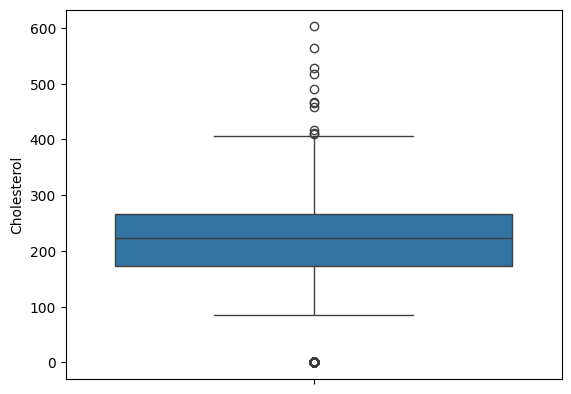

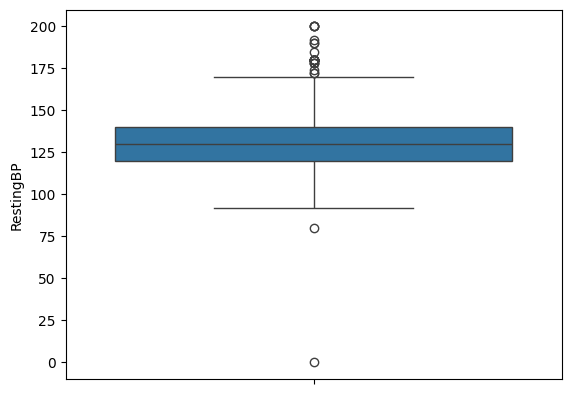

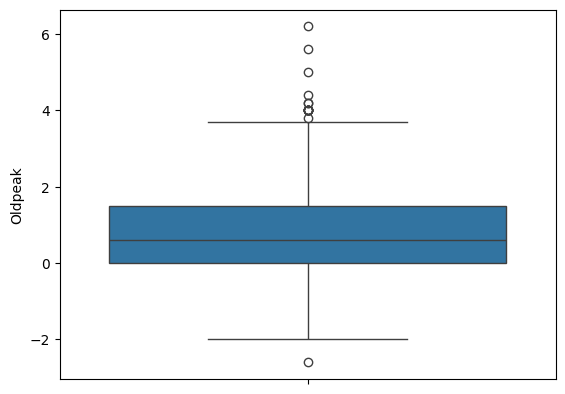

In [9]:
for column in ["Cholesterol", "RestingBP", "Oldpeak"]:
    sns.boxplot(y=column, data=df_copy)
    plt.show()

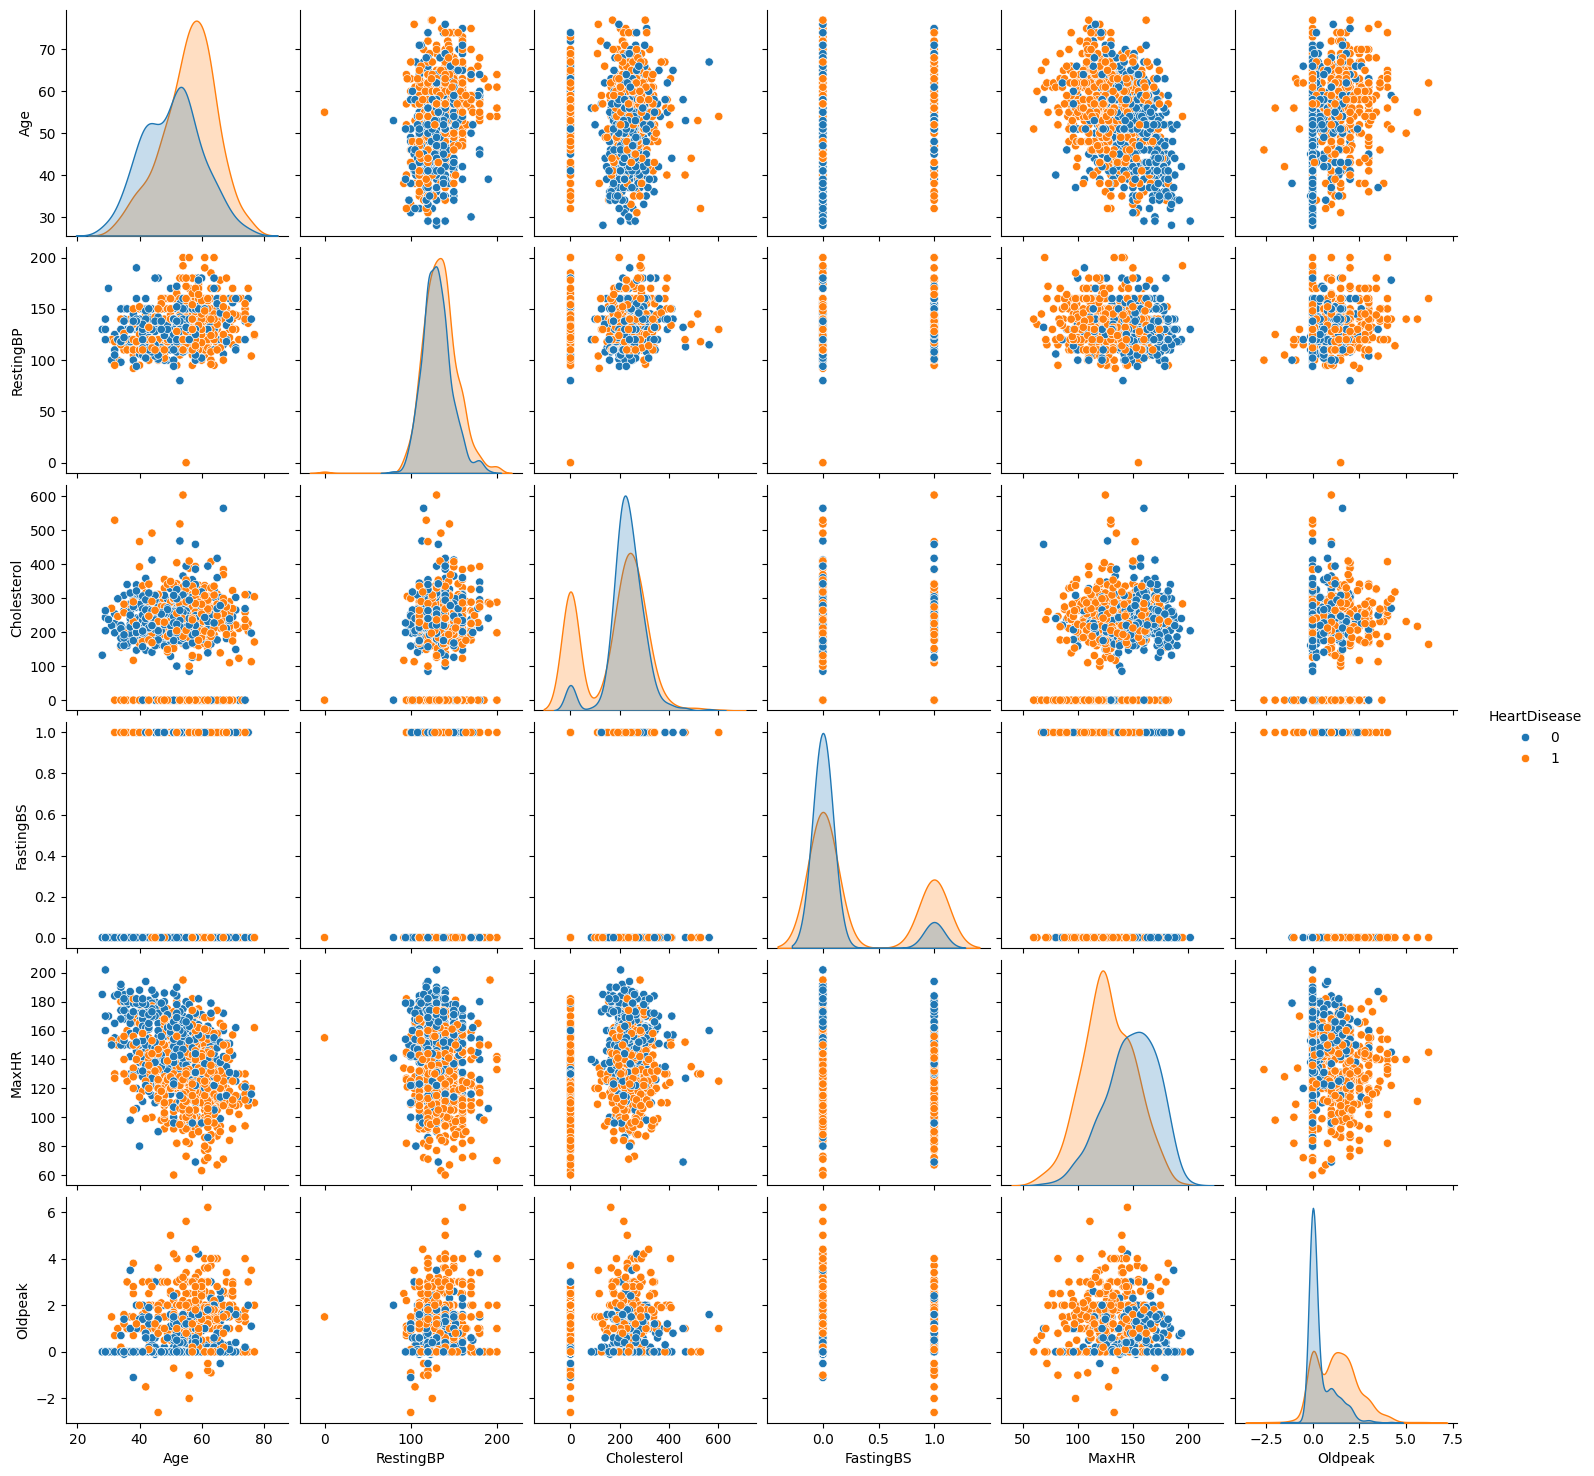

In [10]:
sns.pairplot(df_copy, hue="HeartDisease")

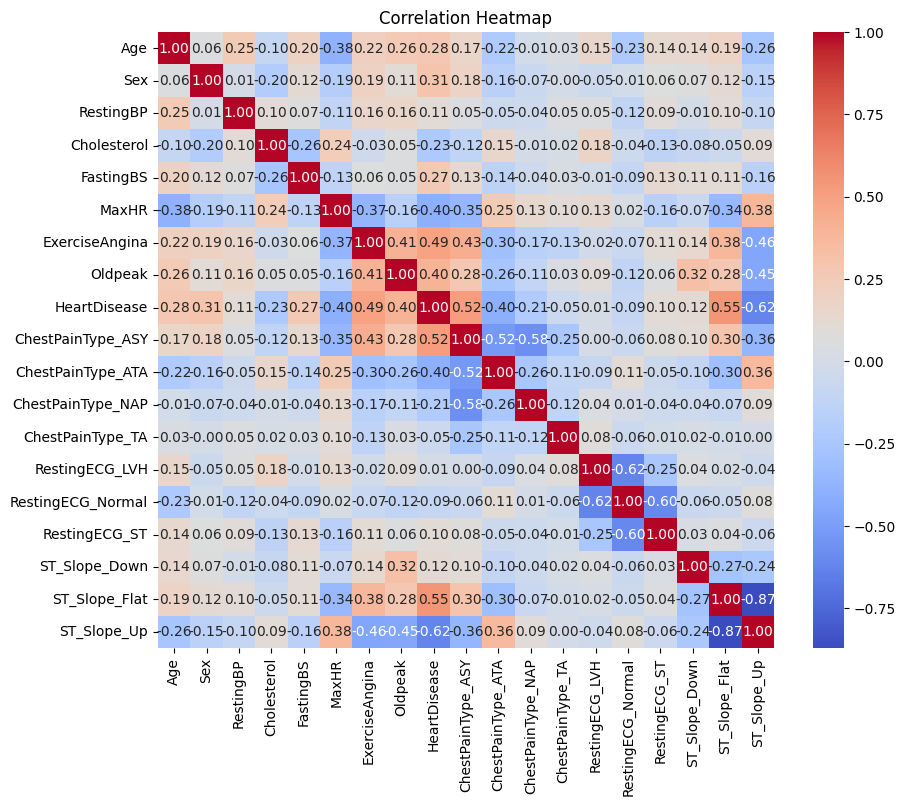

In [11]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Solving problems with data

check for label imbalance

In [12]:
df["HeartDisease"].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

remove outliers

In [13]:
def remove_outliers_iqr(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


remove highly correlated features

In [14]:
df = df.drop("ST_Slope_Flat", axis=1)

In [15]:
labels = df.pop("HeartDisease")

scaling data

In [16]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

# Dimension Reduction

In [17]:
def reduce_dimension(df, method="PCA"):
    match method:
        case "TSNE" :
            tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=50)
            return tsne.fit_transform(df)
        case "PCA" | _:
            pca = PCA(n_components=2)
            return pca.fit_transform(df)

In [18]:
def plot_reduced_features(features, labels, title=""):
    x, y = zip(*features)
    sns.scatterplot(x=x, y=y, hue=labels)
    plt.title(title)
    plt.show()

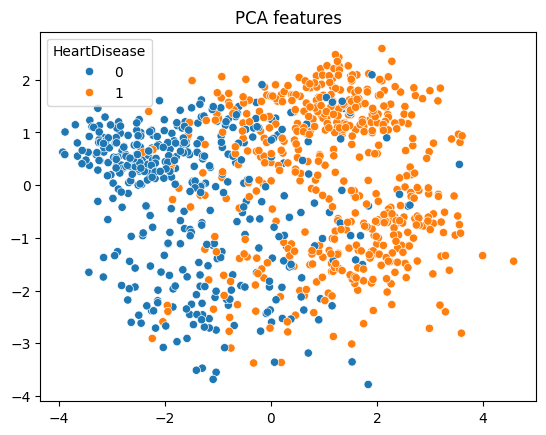

In [19]:
df_pca = reduce_dimension(scaled_df, method="PCA")
plot_reduced_features(df_pca, labels, "PCA features")

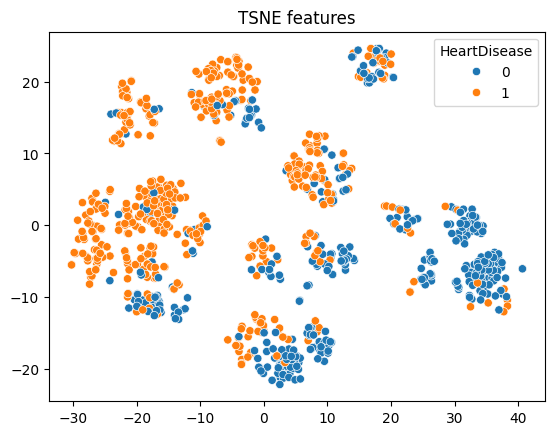

In [20]:
df_tsne = reduce_dimension(scaled_df, method="TSNE")
plot_reduced_features(df_tsne, labels, "TSNE features")

# Clustering

In [21]:
def get_kmeans_results(df):
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
    kmeans.fit(df)
    return kmeans.predict(df)

In [22]:
def get_agglomerative_clustering_results(df):
    clustering = AgglomerativeClustering(n_clusters=2)
    clustering.fit(df)
    return clustering.labels_

adjusted_rand_score: 0.42654587392498855


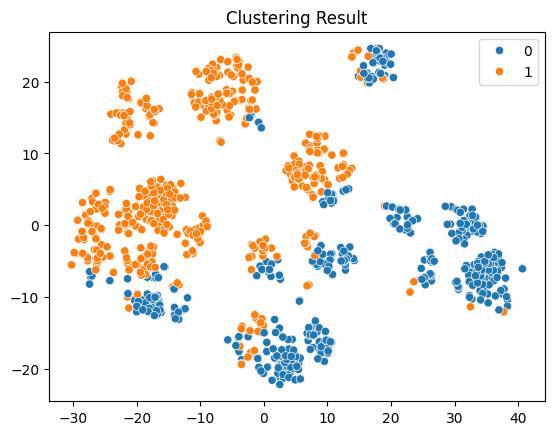

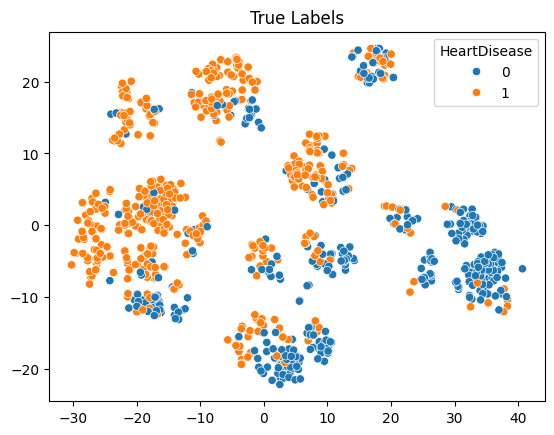

In [23]:
clustering_results = get_kmeans_results(scaled_df)
print(f"adjusted_rand_score: {adjusted_rand_score(clustering_results, labels)}")

plot_reduced_features(df_tsne, clustering_results, "Clustering Result")
plot_reduced_features(df_tsne, labels, "True Labels")

adjusted_rand_score: 0.22363740909006138


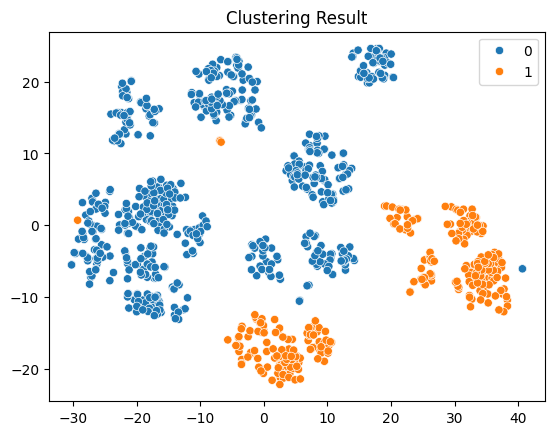

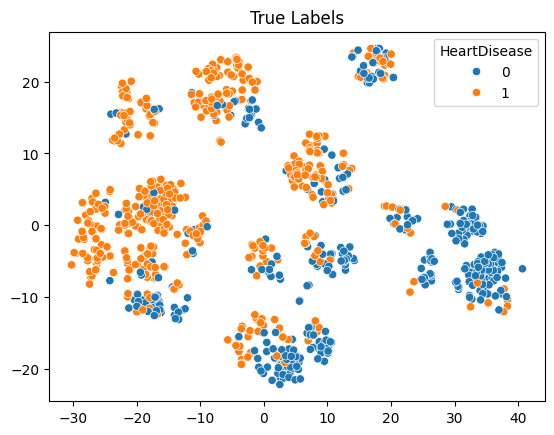

In [24]:
clustering_results = get_agglomerative_clustering_results(scaled_df)
print(f"adjusted_rand_score: {adjusted_rand_score(clustering_results, labels)}")

plot_reduced_features(df_tsne, clustering_results, "Clustering Result")
plot_reduced_features(df_tsne, labels, "True Labels")